In [ ]:
# simple pushout tinker / demo: use TIS to push out of a well

### 1. System setup
- Diffusive dynamics in a single Gaussian well.
- This is a toy version of the situation where our simulation might be stuck in a single metastable well, and we want to "push" out toward the edges of the well, to maximize our chance of escaping to another metastable well.

In [1]:
import numpy as np
import numpy.random as npr

def q(x):
    return np.exp(-np.sum(x**2))

class SphericalInterface():
    ''' Return True if you're inside the interface '''
    
    def __init__(self,lam=0.2):
        self.lam=lam
    
    def __call__(self,x):
        return np.sqrt(np.sum(x**2))<=self.lam

In [2]:
def simulate_diffusion(x_0,q_fxn,interface_indicator_fxn,
                       step_size=0.01,max_steps=10000):
    
    # store trajectory in an array
    traj = np.zeros((max_steps+1,len(x_0)))
    traj[0] = x_0
    old_q = q_fxn(x_0)
    if not interface_indicator_fxn(x_0):
        raise(ArgumentError('x_0 must start inside the interface!'))
    
    for i in range(max_steps):
        
        # if we reach / cross the target interface, yay! stop immediately
        if not interface_indicator_fxn(traj[i]):
            return traj[:i+1]
        
        # else propagate another step
        else:
            prop = traj[i]+npr.randn(len(x_0))*step_size
            new_q = q_fxn(prop)
            
            if new_q/old_q>npr.rand():
                traj[i+1] = prop
                old_q = new_q
            else:
                traj[i+1] = traj[i]
    return traj

In [3]:
traj = simulate_diffusion(np.zeros(2),q,SphericalInterface(0.2),step_size=0.01)

In [4]:
len(traj)

348

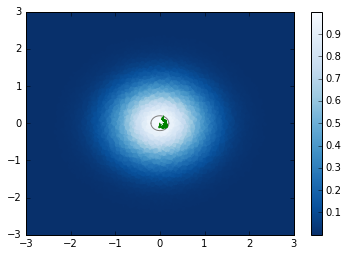

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_circle(radius=0.2):
    x = np.linspace(-radius,radius,500)
    y = np.sqrt(radius**2-x**2)
    plt.plot(x,y,c='grey')
    plt.plot(x,-y,c='grey')
    
width=6
x = npr.rand(100000,2)*width-width/2.0
c = np.array([q(x_) for x_ in x])

plt.scatter(x[:,0],x[:,1],c=c,linewidths=0,cmap='Blues_r')

radius = 0.2
outside_interface = SphericalInterface(radius)
plot_circle(radius)

plt.plot(traj[:,0],traj[:,1],c='green')
plt.xlim(-width/2.0,width/2.0)
plt.ylim(-width/2.0,width/2.0)
plt.colorbar()

In [6]:
radii = np.linspace(0.2,2.0,50)

interfaces = [SphericalInterface(lam) for lam in radii]

In [7]:
def sample_ensemble(x_0,interface,n_attempts=100,max_traj_length=500):
    trajs = [simulate_diffusion(x_0,q,interface,max_steps=max_traj_length) for _ in range(n_attempts)]
    return [traj for traj in trajs if len(traj)<=max_traj_length]

In [8]:
ensembles = [sample_ensemble(np.zeros(2),i) for i in interfaces]

On this finite trajectory budget, we essentially never saw beyond radius 1.

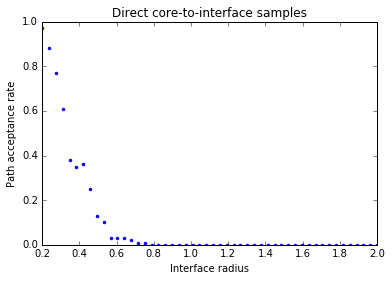

In [9]:
plt.plot(radii,[len(ensemble)/100.0 for ensemble in ensembles],'.')
plt.xlabel('Interface radius')
plt.ylabel('Path acceptance rate')
plt.title('Direct core-to-interface samples')

(-2, 2)

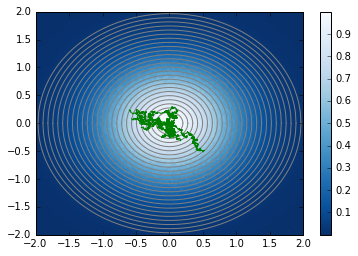

In [10]:
plt.scatter(x[:,0],x[:,1],c=c,linewidths=0,cmap='Blues_r')
plt.colorbar()

for i in range(len(radii))[::2]:
    radius = radii[i]
    plot_circle(radius)
    
    if len(ensembles[i])>0:
        traj = ensembles[i][0]
        plt.plot(traj[:,0],traj[:,1],c='green')
plt.xlim(-2,2)
plt.ylim(-2,2)

In [11]:
def shoot_from_paths(paths,interface,n_shooting_moves=1000):
    ''' Shoot from paths until you hit the interface'''
    
    samples = []
    
    for i in range(n_shooting_moves):
        # randomly select a path
        path = paths[npr.randint(len(paths))]
        
        ## randomly select a position on that path
        #x_0 = path[npr.randint(len(path))]
        
        # constrained 1-way shooting move-- shoot from last position on path, and
        # since the system doesn't have any momentum, just append to the path 
        sample = sample_ensemble(path[-1],interface,n_attempts=1)
        if len(sample)>0:
            samples.append(sample[0])
    return samples

In [12]:
# get 100 initial samples that reach the innermost interface
shooting_samples = [sample_ensemble(np.zeros(2),interfaces[0],n_attempts=1000)[:100]]

# use the paths that reach interface i to help you reach interface i+1
for i in range(1,len(interfaces)):
    shooting_samples.append(shoot_from_paths(shooting_samples[i-1],interfaces[i],n_shooting_moves=100))

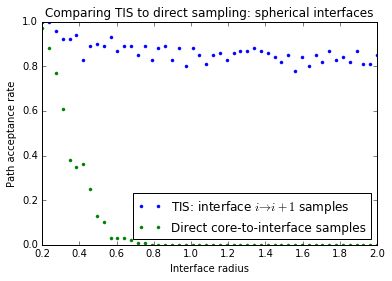

In [13]:
plt.plot(radii,[1.0*len(ensemble)/len(shooting_samples[0]) for ensemble in shooting_samples],'.',label=r'TIS: interface $i \to i+1$ samples')
plt.plot(radii,[len(ensemble)/100.0 for ensemble in ensembles],'.',label='Direct core-to-interface samples')

plt.xlabel('Interface radius')
plt.ylabel('Path acceptance rate')
plt.title('Comparing TIS to direct sampling: spherical interfaces')
plt.legend(loc='best')

(0, 1)

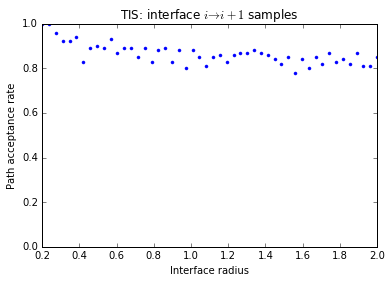

In [14]:
plt.plot(radii,[1.0*len(ensemble)/len(shooting_samples[0]) for ensemble in shooting_samples],'.')
plt.xlabel('Interface radius')
plt.ylabel('Path acceptance rate')
plt.title(r'TIS: interface $i \to i+1$ samples')
plt.ylim(0,1)

### 2. Unknown interfaces: MSMs
- If we didn't know beforehand that concentric spherical interfaces were the way to go, could we use an MSM to help us "climb" out of the well?

In [15]:
# first, collect a ton of samples
npr.seed(0)
trajs = [simulate_diffusion(np.zeros(2),q,lambda x:True,max_steps=10000) for _ in range(100)]

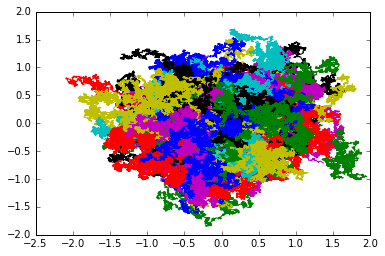

In [16]:
for traj in trajs:
    plt.plot(traj[:,0],traj[:,1])

In [17]:
# cluster them
import pyemma
import pyemma.coordinates
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(trajs,max_iter=1000)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

kmeans iterations:   5% (  53/1000) [#                             ] eta 09:27 /12-03-16 01:19:25 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 54 steps.
getting output of MiniBatchKmeansClustering: 100% (300/300) [######] eta 00:01 |

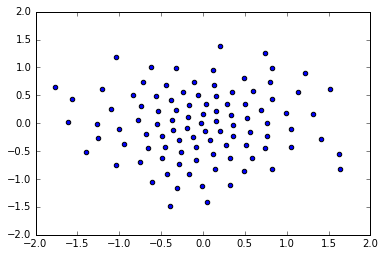

In [18]:
plt.scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1])

In [19]:
# build an MSM
msm = pyemma.msm.estimate_markov_model(dtrajs,10)

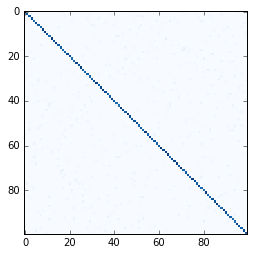

In [20]:
plt.imshow(msm.transition_matrix,interpolation='none',cmap='Blues')

In [21]:
np.trace(msm.transition_matrix)/len(msm.transition_matrix)

0.83764064338689292

In [22]:
# estimate MFPT between all discrete states
def mfpt_matrix(msm):
    n = msm.nstates_full
    mfpt = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            mfpt[i,j] = msm.mfpt(i,j)
    return mfpt
mfpt = mfpt_matrix(msm)

In [23]:
msm.nstates,msm.nstates_full

(100, 100)

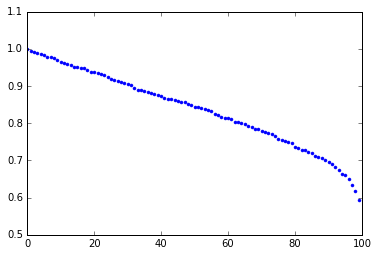

In [24]:
# plot eigenvalues
plt.plot(msm.eigenvalues(),'.')

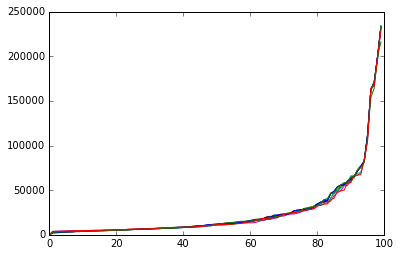

In [25]:
# plot some random outward MFPT vectors
for i in range(10):
    ind = npr.randint(len(mfpt))
    plt.plot(sorted(mfpt[ind]))

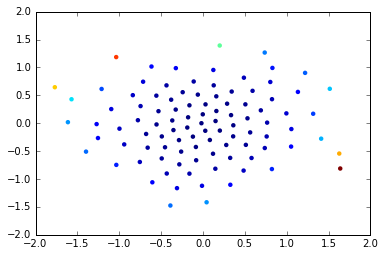

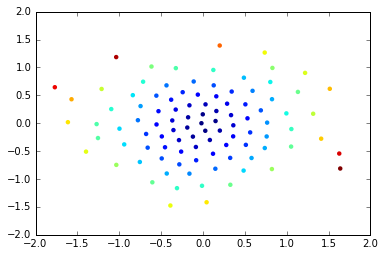

In [26]:
# color by max MFPT out

plt.scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1],c=mfpt.max(0),linewidths=0)
plt.figure()
plt.scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1],c=np.log(mfpt.max(0)),linewidths=0)

In [27]:
len(kmeans.clustercenters[:,0]),len(mfpt)

(100, 100)

In [28]:
np.argmin(mfpt.max(0))

65

In [29]:
# color in order of increasing max MFPT out
n = msm.nstates
ranked = sorted(np.arange(n),key=lambda i:mfpt.max(0)[i])
ranks = sorted(np.arange(n),key=lambda i:ranked[i])

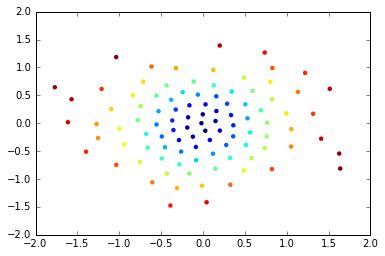

In [30]:
plt.scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1],c=ranks,linewidths=0)

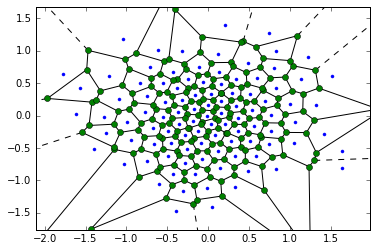

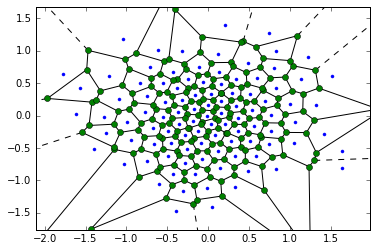

In [31]:
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(kmeans.clustercenters)

voronoi_plot_2d(vor)

In [32]:
# create animation of the voronoi cells being added!

In [34]:
kmeans.assign(np.zeros((1,2)))[0]

65

In [35]:
class KmeansInterface():
    ''' return True if x is inside one of the included cells'''
    
    def __init__(self,kmeans,included_indices):
        self.kmeans = kmeans
        self.included_indices = included_indices
   
    def __call__(self,x):
        x_ = x.reshape((1,len(x)))
        cell = self.kmeans.assign(x_)[0]
        return cell in self.included_indices

In [36]:
k = KmeansInterface(kmeans,ranked[:2])
k(np.zeros(2))

True

In [37]:
kmeans_interfaces = [KmeansInterface(kmeans,ranked[:i]) for i in range(1,len(ranked))]

In [38]:
# get initial samples that reach the innermost interface
n_samples=250
center = kmeans.clustercenters[ranked[0]]
shooting_samples = [sample_ensemble(center,kmeans_interfaces[0],n_attempts=1000)[:n_samples]]

In [39]:
print(center)

[-0.01840059 -0.00033934]


In [40]:
# use the paths that reach interface i to help you reach interface i+1
for i in range(1,len(kmeans_interfaces)):
    shooting_samples.append(shoot_from_paths(shooting_samples[i-1],kmeans_interfaces[i],n_shooting_moves=n_samples))

In [41]:
len(shooting_samples)

99

In [42]:
len(shooting_samples[0][0])

29

In [43]:
brute_force_ensembles = [sample_ensemble(kmeans.clustercenters[ranked[0]],i,n_attempts=n_samples) for i in kmeans_interfaces]

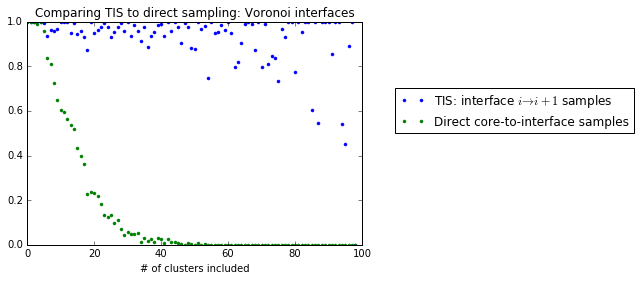

In [44]:
plt.plot([1.0*len(ensemble)/len(shooting_samples[0]) for ensemble in shooting_samples],'.',label=r'TIS: interface $i \to i+1$ samples')
plt.plot([1.0*len(ensemble)/len(shooting_samples[0]) for ensemble in brute_force_ensembles],'.',label='Direct core-to-interface samples')
plt.xlabel('# of clusters included')
plt.legend(loc=(1.1,0.5))
plt.title('Comparing TIS to direct sampling: Voronoi interfaces')

<Container object of 100 artists>

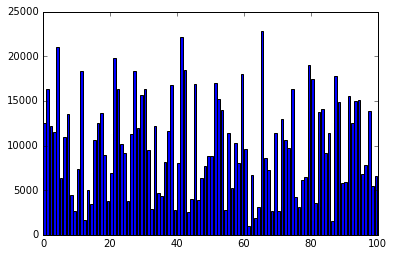

In [52]:
counts = [np.sum(np.hstack(dtrajs)==i) for i in range(msm.nstates)]
plt.bar(range(msm.nstates),counts)

### Problems
- How many voronoi cells to add at a time?
    - Unclear! Here added one at a time
- Overlapping interfaces
    - Interface $i+1$ typically differs from interface $i$ only in a small area
- Can't fine-tune the "step size"
    

### How else could we define interfaces?

Assuming we have a ranking on clusters (s_1,...s_n), we generate a series of interfaces that are the solutions to a classification problem: separating kinetic set A_i and kinetic set B_i, where set A_i = {s_1,...,s_i} and B_i = {s_i+1,...,s_n}. Hopefully we've chosen a ranking on clusters such that 

If we use a Voronoi tesselation, the interfaces are the 1-nearest-neighbor solutions to those classification problems, where the training set includes only the Voronoi generators.

We can use other classifiers!

Assuming we have identified one or more metastable sets, we can also define interfaces by:
- One-class SVM surface given a metastable set
- SVM classifier between generators of A_i and B_i
- SVM classifier between points included in A_i and B_i

Could also draw separating surfaces in tICA coordinates?

In [53]:
X = np.vstack(trajs)
y_all = np.hstack(dtrajs)

def binarize_classification_problem(y_all,selected_indices):
    y = np.zeros(len(y_all),dtype=int)
    for i in selected_indices:
        y += y_all==i
    return y

In [54]:
y = binarize_classification_problem(y_all,ranked[:10])

In [55]:
y_all.shape,X.shape

((1000100,), (1000100, 2))

In [56]:
from sklearn import svm

In [57]:
%%time
clf = svm.NuSVC(nu=0.1)

thinning=100
clf.fit(X[::thinning],y[::thinning])

CPU times: user 495 ms, sys: 40.8 ms, total: 536 ms
Wall time: 542 ms


In [58]:
len(X[::thinning])

10001

In [59]:
# could also do something with only the cluster centers

In [60]:
clf.n_support_

array([503, 501], dtype=int32)

In [62]:
def balance_classification_problem(y_bin):
    inds_0 = np.arange(len(y_bin))[y_bin==0]
    inds_1 = np.arange(len(y_bin))[y_bin==1]
    
    larger = 0
    if len(inds_1) > len(inds_0): larger=1
    smaller = abs(1-larger)
    
    n = min(len(inds_0),len(inds_1))
    
    npr.shuffle(inds_0)
    npr.shuffle(inds_1)
    
    return np.hstack([inds_0[:n],inds_1[:n]])

def fit_svm(X,y,included_indices,max_points=10000,nu=0.1):
    
    y_ = binarize_classification_problem(y,included_indices)
    
    inds = balance_classification_problem(y_)
    
    thinning = max(int(len(inds) / max_points),1)
    
    clf = svm.NuSVC(nu)
    clf.fit(X[inds][::thinning],y_[inds][::thinning])
    
    return clf

class SVMInterface():
    ''' return True if x is inside the interface'''
    
    def __init__(self,X,y,included_indices):
        self.X = X
        self.y = y
        self.included_indices = included_indices
        self.clf = fit_svm(X,y,included_indices)
        
    def __call__(self,x):
        pred = self.clf.predict(x.reshape(1,-1))[0]
        return bool(pred)

In [63]:
class SVMCenterInterface():
    def __init__(self,kmeans,included_indices):
        self.kmeans = kmeans
        self.included_indices = included_indices
        self.clf = svm.SVC()
        y = np.zeros(len(kmeans.clustercenters))
        for i in included_indices:
            y[i] = 1
        self.clf.fit(self.kmeans.clustercenters,y)
    def __call__(self,x):
        pred = self.clf.predict(x.reshape(1,-1))[0]
        return bool(pred)

In [64]:
np.sum(y==0),np.sum(y==1)

(804531, 195569)

In [65]:
balance_classification_problem(y).shape

(391138,)

In [66]:
svm_interfaces = [SVMCenterInterface(kmeans,ranked[:i]) for i in range(1,len(ranked))]

In [67]:
svm_interfaces[0](center)

False

In [69]:
# get initial samples that reach the innermost interface
n_samples=250
center = kmeans.clustercenters[ranked[0]]
shooting_samples = [sample_ensemble(center,svm_interfaces[0],n_attempts=1000)[:n_samples]]

RuntimeError: x_0 must start inside the interface!

In [ ]:
# use the paths that reach interface i to help you reach interface i+1
for i in range(1,len(kmeans_interfaces)):
    shooting_samples.append(shoot_from_paths(shooting_samples[i-1],svm_interfaces[i],n_shooting_moves=n_samples))

In [ ]:
interface = svm_interfaces[-1]
interface.clf.n_support_

In [46]:
lim = 3


xx, yy = np.meshgrid(np.linspace(-lim, lim, 100),
                     np.linspace(-lim, lim, 100))
# plot the decision function for each datapoint on the grid

'''
plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
               origin='lower',
               cmap=plt.cm.PuOr_r
              )
'''

for i in range(len(svm_interfaces)):
    plt.figure()
    clf = svm_interfaces[i].clf
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    
    #voronoi_plot_2d(vor)
    contours = plt.contourf(xx, yy, Z, levels=[0,1000], linewidths=1,c='grey',
                           linetypes='--',alpha=0.2)
    #plt.scatter(X[:, 0], X[:, 1], s=30, c=y, linewidths=0, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.axis([-lim, lim, -lim, lim])
    plt.savefig('svm_center_interface_{0}.jpg'.format(i))
    plt.close()

NameError: name 'svm_interfaces' is not defined

In [ ]:
brute_force_ensembles = [sample_ensemble(center,i,n_attempts=n_samples) for i in svm_interfaces]

In [ ]:
%%time
svm_interfaces[0](center)

In [ ]:
plt.plot([1.0*len(ensemble)/len(shooting_samples[0]) for ensemble in shooting_samples],'.',label=r'TIS: interface $i \to i+1$ samples')
plt.plot([1.0*len(ensemble)/len(shooting_samples[0]) for ensemble in brute_force_ensembles],'.',label='Direct core-to-interface samples')
plt.xlabel('# of clusters included')
plt.legend(loc=(1.1,0.5))
plt.title('Comparing TIS to direct sampling: SVM interfaces')
plt.ylim(0,1)

In [ ]:
# another case: 1-class SVM-- bootstrap the interface as you go

In [ ]:
ensembles = [[simulate_diffusion(np.zeros(2),q,lambda x:True,max_steps=1000) for i in range(n_samples)]]
all_trajs = ensembles[0]
interfaces = []

class SVMInterface():
    def __init__(self,svm):
        self.svm = svm
    def __call__(self,x):
        return self.svm.predict(x.reshape(1,-1))[0]==1
n_interfaces = 100
    
for i in range(1,n_interfaces):
    print(i)
    clf = svm.OneClassSVM()
    clf.fit(np.vstack(trajs))
    interface_indicator = SVMInterface(clf)
    
    interfaces.append(interface_indicator)
    
    for j in range(n_samples):
        path = trajs[i-1][npr.randint(len(trajs[i-1]))]
        new_ensemble = sample_ensemble(path[-1],interface=interface_indicator,n_attempts=1)
        ensembles.append(new_ensemble)

### Another case: 2 metastable basins

In [3]:
# two wells!
def q_2(x):
    return np.exp(-np.sum(x**2)) + np.exp(-np.sum((x-3)**2))

In [4]:
# starting in one well
trajs = [simulate_diffusion(np.zeros(2),q_2,lambda x:True,max_steps=10000,step_size=0.1) for _ in range(10)]

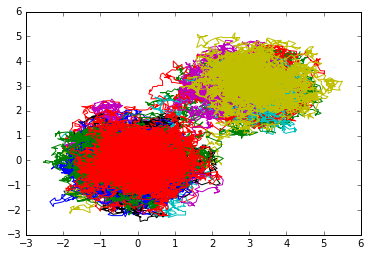

In [6]:
for traj in trajs:
    plt.plot(traj[:,0],traj[:,1])

In [8]:
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(trajs,max_iter=1000)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

kmeans iterations:  12% ( 129/1000) [###                           ] eta 00:39 /14-03-16 09:36:13 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 130 steps.
getting output of MiniBatchKmeansClustering: 100% (30/30) [########] eta 00:01 -

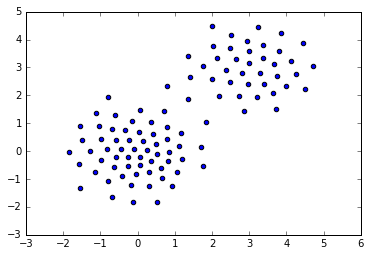

In [9]:
plt.scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1])

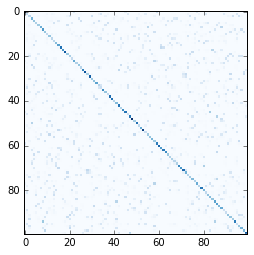

In [12]:
msm = pyemma.msm.estimate_markov_model(dtrajs,10)
mfpt = mfpt_matrix(msm)

plt.imshow(msm.transition_matrix,interpolation='none',cmap='Blues')

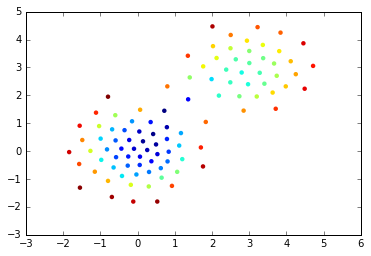

In [13]:
n = msm.nstates
ranked = sorted(np.arange(n),key=lambda i:mfpt.max(0)[i])
ranks = sorted(np.arange(n),key=lambda i:ranked[i])
plt.scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1],c=ranks,linewidths=0)

In [14]:
import networkx as nx

In [15]:
graph = nx.DiGraph(msm.transition_matrix)

In [16]:
betweenness = nx.betweenness_centrality(graph)

In [17]:
betweenness = [betweenness[i] for i in range(len(betweenness))]

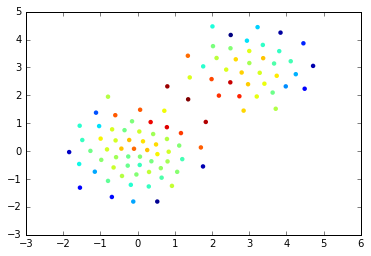

In [18]:
plt.scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1],c=np.log(betweenness),linewidths=0)